In [1]:
"""
Pairwise registration evaluation with meanshift filter denoising for both affine and deformable registration.
"""
import sys
sys.path.append('..')
sys.path.append('../../spami/')
import time

import json
import os
from os.path import join, exists
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from greedyfhist.registration import GreedyFHist, get_default_args


from miit.reg_graph import RegGraph
from miit.utils.utils import create_if_not_exists, clean_configs
from miit.utils.metrics import compute_tre, compute_tre_sections_

def get_core_names():
    return [x.split('.')[0] for x in os.listdir('../../spami/configs/cores_hr/')]


# def get_default_args():
#     return {
#         'resolution': 1024,
#         'use_segmentation_masks': True,    
#         'output_dir': '../save_directories/temp_pairwise/',
#         'tmp_dir': '../save_directories/temp_pairwise/tmp',
#         'cleanup_temporary_directories': False,
#         'remove_temp_directory': False,
#         'cost_fun': 'WNCC',
#         'ia': 'ia-com-init',
#         'affine_use_denoising': True,
#         'deformable_use_denoising': True
# }

reg_configs = [
    # {'resolution': (128, 128), 'kernel': 2},
    # {'resolution': (256, 256), 'kernel': 3},
    # {'resolution': (512, 512), 'kernel': 5},
    {'resolution': (1024, 1024), 'kernel': 10},
    # {'resolution': (2048, 2048), 'kernel': 20}
]

def main():
    skip_processed_cores = True
    root_dir = '../save_directories/pairwise_analysis/greedy_f_hist_params_no_def_denoising'
    if not os.path.exists(root_dir):
        os.mkdir(root_dir)
    core_names = get_core_names()
    df_all = pd.DataFrame()
    # resolutions = [1024]
    registerer = GreedyFHist(path_to_greedy='/mnt/work/workbench/maximilw/applications/test/greedy/build2/greedy')

    for reg_config in reg_configs:
    # for resolution in resolutions:
        resolution = reg_config['resolution'][0]
        res_target_dir = f'{root_dir}/{resolution}'
        create_if_not_exists(res_target_dir)
        for core_name in core_names:
            print(f'Working resolution: {resolution} and core: {core_name}')       
            target_dir = join(res_target_dir, core_name)
            # if os.path.exists(target_dir) and skip_processed_cores:
            #     print('Already processed!')
            #     continue
            create_if_not_exists(target_dir)
            config_path = os.path.join('../../spami/configs/cores_hr/', core_name + '.json')
            with open(config_path, 'r') as f:
                config = json.load(f)
                config = clean_configs(config)
                # config = filter_node_ids(config, section_ids)
            graph = RegGraph.from_config(config)        
            df_core = pd.DataFrame()
            section_ids = list(graph.sections)
            # paddings = get_symmetric_padding_for_sections([graph.sections[x] for x in section_ids])

            for i in range(len(section_ids)-1):
                source_idx = section_ids[i]
                target_idx = section_ids[i+1]
                source_section = graph.sections[source_idx].copy()
                target_section = graph.sections[target_idx].copy()
                if source_section.landmarks is None or target_section.landmarks is None:
                    continue
                print(f'Now processing: {source_idx} and {target_idx}')
                sub_dir = join(target_dir, f'{source_idx}_{target_idx}')
                create_if_not_exists(sub_dir)
                # args = get_default_args()
                args = get_default_args()
                args['resolution'] = reg_config['resolution']
                args['kernel'] = reg_config['kernel']
                args['deformable_use_denoising'] = False
                start = time.time()
                output_dir = 'save_directories/temp_nb/'
                temp_dir = 'save_directories/temp_nb/temp'
                args['output_dir'] = output_dir
                
                if exists(args['output_dir']):
                    shutil.rmtree(args['output_dir'])
                create_if_not_exists(args['output_dir'])
                registration_result = registerer.register(moving_img=source_section.image.data,
                                                                                 fixed_img=target_section.image.data,
                                                                                 moving_img_mask=source_section.segmentation_mask.data,
                                                                                 fixed_img_mask=target_section.segmentation_mask.data,
                                                                                 args=args)  
                end = time.time()
                transform_result = registerer.transform_pointset(source_section.landmarks.pointcloud, registration_result)
                warped_section = source_section.warp(registerer, registration_result, args) # Warp section here

                duration = end - start
                mean_rtre, median_rtre, mean_tre, median_tre = compute_tre_sections_(target_section, warped_section)
                row = {
                    'core_name': core_name,
                    'fixed_section_id': target_idx,
                    'moving_section_id': source_idx,
                    'mean_rtre': mean_rtre,
                    'median_rtre': median_rtre,
                    'mean_tre': mean_tre,
                    'median_tre': median_tre,
                    'duration': duration,
                    'resolution': resolution
                }
                print(row)
                print(f'Duration: {duration}.')
                row = pd.DataFrame(row, index=[0])
                df_core = pd.concat([df_core, row]).reset_index(drop=True)
            df_core.to_csv(join(target_dir, 'stats.csv'))
            df_all = pd.concat([df_all, df_core]).reset_index(drop=True)
        df_all.to_csv(join(root_dir, 'stats.csv'))


WARNING ⚠️ user config directory '/mnt/work/workbench/maximilw/.config/Ultralytics' is not writeable, defaulting to '/tmp' or CWD.Alternatively you can define a YOLO_CONFIG_DIR environment variable for this path.


In [2]:
skip_processed_cores = True
root_dir = '../save_directories/pairwise_analysis/greedy_f_hist_params_no_def_denoising'
if not os.path.exists(root_dir):
    os.mkdir(root_dir)
core_names = get_core_names()
df_all = pd.DataFrame()
# resolutions = [1024]
registerer = GreedyFHist(path_to_greedy='/mnt/work/workbench/maximilw/applications/test/greedy/build2/greedy')

for reg_config in reg_configs:
# for resolution in resolutions:
    resolution = reg_config['resolution'][0]
    res_target_dir = f'{root_dir}/{resolution}'
    create_if_not_exists(res_target_dir)
    for core_name in core_names:
        print(f'Working resolution: {resolution} and core: {core_name}')       
        target_dir = join(res_target_dir, core_name)
        # if os.path.exists(target_dir) and skip_processed_cores:
        #     print('Already processed!')
        #     continue
        create_if_not_exists(target_dir)
        config_path = os.path.join('../../spami/configs/cores_hr/', core_name + '.json')
        with open(config_path, 'r') as f:
            config = json.load(f)
            config = clean_configs(config)
            # config = filter_node_ids(config, section_ids)
        graph = RegGraph.from_config(config)        
        df_core = pd.DataFrame()
        section_ids = list(graph.sections)
        # paddings = get_symmetric_padding_for_sections([graph.sections[x] for x in section_ids])

        for i in range(len(section_ids)-1):
            source_idx = section_ids[i]
            target_idx = section_ids[i+1]
            source_section = graph.sections[source_idx].copy()
            target_section = graph.sections[target_idx].copy()
            if source_section.landmarks is None or target_section.landmarks is None:
                continue
            print(f'Now processing: {source_idx} and {target_idx}')
            sub_dir = join(target_dir, f'{source_idx}_{target_idx}')
            create_if_not_exists(sub_dir)
            # args = get_default_args()
            args = get_default_args()
            args['resolution'] = reg_config['resolution']
            args['kernel'] = reg_config['kernel']
            args['deformable_use_denoising'] = False
            start = time.time()
            output_dir = 'save_directories/temp_nb/'
            temp_dir = 'save_directories/temp_nb/temp'
            args['output_dir'] = output_dir

            if exists(args['output_dir']):
                shutil.rmtree(args['output_dir'])
            create_if_not_exists(args['output_dir'])
            registration_result = registerer.register(moving_img=source_section.image.data,
                                                                             fixed_img=target_section.image.data,
                                                                             moving_img_mask=source_section.segmentation_mask.data,
                                                                             fixed_img_mask=target_section.segmentation_mask.data,
                                                                             args=args)  
            end = time.time()  
            break
        break
    break

Working resolution: 1024 and core: 048_01
Now processing: 1 and 2


In [14]:
from greedyfhist.utils.metrics import compute_tre

transformation_result = registerer.transform_pointset(source_section.landmarks.data, registration_result)
warped_pointset = transformation_result.final_transform.pointcloud
target_pointset = target_section.landmarks.data
shape = target_section.image.data.shape
mean_rtre, median_rtre, mean_tre, median_tre = compute_tre(target_pointset, warped_pointset, shape)

KeyError: 'label'

In [16]:
warped_pointset

,x,y
0,265.210837,1266.706282
1,463.488194,1355.518925
2,267.094534,1179.277532
3,793.858396,1507.705532
4,640.697718,1331.609656
...,...,...
63,1450.138269,1720.097406
64,1738.852115,1933.196075
65,1769.698665,1783.477311
66,2045.716931,2032.848220


In [11]:
source_section.landmarks.data

,Unnamed: 0,label,x,y
0,0,Pt-0,849.868854,444.017820
1,1,Pt-1,917.214262,644.816631
2,2,Pt-2,912.515745,385.322783
3,3,Pt-3,1044.074217,990.808430
4,4,Pt-4,1059.735940,754.483674
...,...,...,...,...
63,63,Pt-63,1324.778302,1610.858534
64,64,Pt-64,1354.610155,1963.911390
65,65,Pt-65,1485.302082,1884.054196
66,66,Pt-66,1489.563775,2260.924109


In [5]:
warped_section.image.data

MultiImageTransformationResult(image_transform_results=[ImageTransformationResult(registered_image=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), registered_image_path='save_directories/temp_nb/tmp/0/registered_image.nii.gz', cmdl_log=[CompletedP

TypeError: Image data of dtype object cannot be converted to float

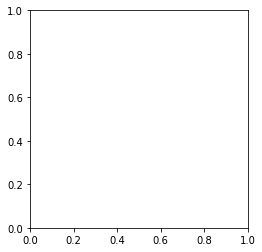

In [4]:
plt.imshow(warped_section.image.data)
plt.plot(warped_section.landmarks.pointcloud.x, warped_section.landmarks.pointcloud.y, '.')

In [7]:
pc = source_section.landmarks.data.copy()
warped_pc = registerer.transform_pointset(pc, registration_result)

In [10]:
warped_pc.final_transform.pointcloud

,x,y
0,265.741527,1266.691434
1,463.645590,1355.414984
2,267.486241,1179.096379
3,793.864335,1507.601592
4,640.540322,1331.618565
...,...,...
63,1449.983843,1720.067709
64,1738.923389,1932.946618
65,1769.749150,1783.492159
66,2045.610021,2032.696764
